# Rock-paper-scissors with Keras/TensorFlow (raw data)

Date: January 9, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for DNN

In [84]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [85]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp
from scipy.fftpack import dct, idct

In [86]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


(array([-0.37369142, -0.37369142,  0.42162334,  0.76247252,  0.33641104,
        -0.71454061, -0.8849652 , -1.08379389, -0.14645863, -0.37369142,
         1.38736269,  1.75661597,  0.62045203, -0.71454061, -0.8849652 ,
        -1.08379389, -0.43049962, -0.43049962,  1.55778728,  1.84182827,
         0.90449301, -0.71454061, -0.99858159, -0.94177339, -0.60092421,
        -0.23167093,  1.61459548,  1.75661597,  1.55778728, -0.31688323,
        -0.8849652 , -0.94177339, -0.60092421,  0.19439055,  1.67140368,
         1.89863647,  1.84182827, -0.03284224, -0.7997529 , -0.8849652 ,
        -0.65773241,  0.42162334,  1.84182827,  1.75661597,  1.33055449,
        -0.31688323, -0.71454061, -0.99858159, -0.7997529 , -0.08965044,
         1.2737463 ,  1.04651351, -0.03284224, -0.71454061, -0.8849652 ,
        -1.08379389, -0.8849652 , -0.65773241, -0.65773241, -0.60092421,
        -0.65773241, -0.71454061, -0.8849652 , -0.99858159]),
 array([0., 1., 0.], dtype=float32))

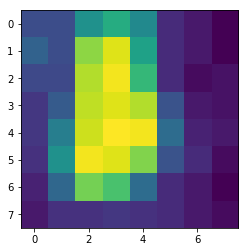

In [87]:
CUTOFF=8
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    img = img.reshape(8,8)
    #img = dct(dct(img, norm='ortho').T, norm='ortho').T
    #img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)    
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    img = img.reshape(8,8)
    #img = dct(dct(img, norm='ortho').T, norm='ortho').T
    #img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data)
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data)
test_lables = np.array(test_labels, dtype='uint8')

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12].reshape((CUTOFF,CUTOFF)))
train_data[12], train_labels[12]

### DNN model

In [88]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu', input_shape=(CUTOFF**2,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 96)                6240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 96)                9312      
_________________________________________________________________
dropout_14 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 291       
Total params: 15,843
Trainable params: 15,843
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

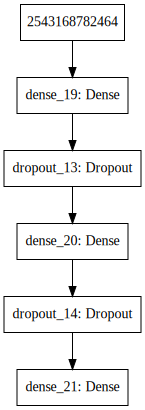

In [90]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training DNN

In [91]:
EPOCHS = 100
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/100
90/90 [==============================] - 0s 5ms/step - loss: 1.7268 - acc: 0.2778 - val_loss: 1.1372 - val_acc: 0.4444
Epoch 2/100
90/90 [==============================] - 0s 175us/step - loss: 1.1913 - acc: 0.4333 - val_loss: 0.9864 - val_acc: 0.5333
Epoch 3/100
90/90 [==============================] - 0s 122us/step - loss: 1.0970 - acc: 0.5222 - val_loss: 0.9457 - val_acc: 0.6000
Epoch 4/100
90/90 [==============================] - 0s 188us/step - loss: 1.0831 - acc: 0.4444 - val_loss: 0.8997 - val_acc: 0.6000
Epoch 5/100
90/90 [==============================] - 0s 122us/step - loss: 1.1042 - acc: 0.4222 - val_loss: 0.8691 - val_acc: 0.5778
Epoch 6/100
90/90 [==============================] - 0s 155us/step - loss: 1.1224 - acc: 0.4333 - val_loss: 0.8363 - val_acc: 0.6889
Epoch 7/100
90/90 [==============================] - 0s 211us/step - loss: 0.9802 - acc: 0.5000 - val_loss: 0.8051 - val_acc: 0.6667
Epoch 8/100
90/90 [========

Epoch 62/100
90/90 [==============================] - 0s 122us/step - loss: 0.1182 - acc: 0.9667 - val_loss: 0.2912 - val_acc: 0.8889
Epoch 63/100
90/90 [==============================] - 0s 89us/step - loss: 0.1785 - acc: 0.9444 - val_loss: 0.3160 - val_acc: 0.8889
Epoch 64/100
90/90 [==============================] - 0s 89us/step - loss: 0.1444 - acc: 0.9333 - val_loss: 0.2875 - val_acc: 0.8889
Epoch 65/100
90/90 [==============================] - 0s 111us/step - loss: 0.1480 - acc: 0.9778 - val_loss: 0.2882 - val_acc: 0.8889
Epoch 66/100
90/90 [==============================] - 0s 100us/step - loss: 0.1189 - acc: 0.9778 - val_loss: 0.2581 - val_acc: 0.8889
Epoch 67/100
90/90 [==============================] - 0s 100us/step - loss: 0.1206 - acc: 0.9889 - val_loss: 0.2465 - val_acc: 0.8889
Epoch 68/100
90/90 [==============================] - 0s 100us/step - loss: 0.1358 - acc: 0.9667 - val_loss: 0.2728 - val_acc: 0.8889
Epoch 69/100
90/90 [==============================] - 0s 89us/st

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


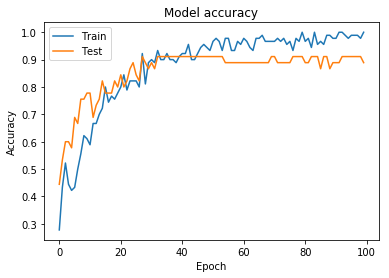

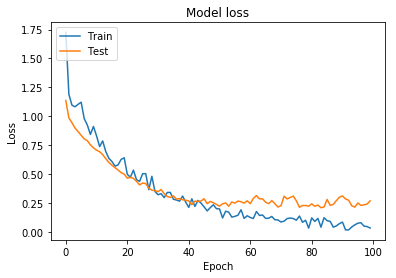

In [92]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Confirmation

In [93]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 64)

In [94]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [95]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)

In [96]:
class_labels

['paper', 'rock', 'scissors']

In [97]:
(activations[-1][:10]*100).astype(int)

array([[ 0,  0, 99],
       [ 0, 87, 12],
       [ 0,  0, 99],
       [ 0, 99,  0],
       [ 0, 99,  0],
       [ 0, 99,  0],
       [ 0,  0, 99],
       [ 0,  3, 96],
       [ 4,  1, 93],
       [ 0,  0, 99]])

In [98]:
test_labels[:10].astype(int)

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])